## WELL WELL WELL XGBOOST DOES NOT WORK STILL AFTER ONE MONTH SO I WILL create new environment and work from here

In [134]:
# Install necessary packages
#%pip install numpy pandas joblib scikit-learn==1.3.1 xgboost==2.1.3

In [135]:
#%pip install matplotlib

In [136]:
#%pip install seaborn

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn / XGBoost imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
import xgboost as xgb

In [138]:
# Load datasets for XGBoost
X_train_clean_mean = np.load("../XGBOOST/X_train_clean_mean.npy")
X_test_clean_mean = np.load("../XGBOOST/X_test_clean_mean.npy")
y_train_clean = np.load("../XGBOOST/y_train_clean.npy")
y_test_clean = np.load("../XGBOOST/y_test_clean.npy")

print("XGBoost-required datasets loaded successfully!")


XGBoost-required datasets loaded successfully!


In [139]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, balanced_accuracy_score, fbeta_score

def evaluate_model_extended(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    gini = 2 * roc_auc - 1  # Gini Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)  # F2-score

    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy:         {accuracy:.3f}")
    print(f"Precision:        {precision:.3f}")
    print(f"Recall:           {recall:.3f}")
    print(f"F1-Score:         {f1:.3f}")
    print(f"F2-Score:         {f2:.3f}")
    print(f"ROC-AUC:          {roc_auc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"MCC:              {mcc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    return accuracy, precision, recall, f1, f2, roc_auc, gini, mcc, balanced_acc, y_pred_prob


In [140]:
import os

def evaluate_and_plot_model_extended(results, y_test, output_dir="../visualizations", prefix="logit"):
    """
    Evaluates models and generates plots for:
    - ROC Curve
    - Confusion Matrix
    - Performance Metrics Bar Chart (including new metrics: Gini, MCC, Balanced Accuracy, F2-Score)

    Args:
        results (dict): Model results containing (accuracy, precision, recall, f1, roc_auc, gini, mcc, balanced_acc, f2, cm, y_pred_prob).
        y_test (array-like): True labels for test set.
        output_dir (str): Path where the evaluation plots will be saved.
        prefix (str): Prefix to use for saving files (e.g., "logit", "xgb", "rf").
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through stored results and plot
    for model_name, (accuracy, precision, recall, f1, roc_auc, gini, mcc, balanced_acc, f2, cm, y_pred_prob) in results.items():
        # Format Model Name for File Naming
        model_name_clean = model_name.replace(" ", "_").lower()

        # Compute additional metrics
        y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary predictions

        # Create a Single Figure with 4 Subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # **Plot ROC Curve**
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        axes[0, 0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', color='blue')
        axes[0, 0].plot([0, 1], [0, 1], linestyle="--", color="black")  # Fixed redundant definition
        axes[0, 0].set_xlabel("False Positive Rate")
        axes[0, 0].set_ylabel("True Positive Rate")
        axes[0, 0].set_title(f"ROC Curve - {model_name}")
        axes[0, 0].legend(loc="lower right")

        # **Plot Confusion Matrix**
        sns.heatmap(
            cm, 
            annot=True, 
            cmap="Blues", 
            fmt="d",
            xticklabels=["Survived (0)", "Died (1)"], 
            yticklabels=["Survived (0)", "Died (1)"],
            ax=axes[0, 1]
        )
        axes[0, 1].set_title(f"Confusion Matrix - {model_name}")
        axes[0, 1].set_ylabel("True Label")
        axes[0, 1].set_xlabel("Predicted Label")

        # **Plot Bar Chart for Model Metrics**
        metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini", "MCC", "Balanced Acc", "F2-Score"]
        metric_values = [accuracy, precision, recall, f1, roc_auc, gini, mcc, balanced_acc, f2]

        barplot = sns.barplot(x=metric_names, y=metric_values, ax=axes[1, 0], palette="coolwarm", edgecolor="black", hue=metric_names)
        axes[1, 0].set_ylim(0, 1)  # Metrics range from 0 to 1
        axes[1, 0].set_title(f"Performance Metrics - {model_name}")
        axes[1, 0].set_ylabel("Score")

        # **Fix set_ticklabels() issue by explicitly setting ticks**
        axes[1, 0].set_xticks(range(len(metric_names)))
        axes[1, 0].set_xticklabels(metric_names, rotation=45, ha="right")

        # **Add Values on Bars**
        for bar in barplot.patches:
            axes[1, 0].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{bar.get_height():.3f}", 
                ha='center', va='bottom', fontsize=10, fontweight="bold", color="black"
            )

        # **Plot Gini Coefficient Separately**
        axes[1, 1].bar(["Gini Coefficient"], [gini], color='purple', edgecolor="black")
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].set_title("Gini Coefficient")
        axes[1, 1].set_ylabel("Score")
        axes[1, 1].text(0, gini, f"{gini:.3f}", ha='center', va='bottom', fontsize=10, fontweight="bold", color="black")

        # **Save the Figure**
        eval_plot_path = os.path.join(output_dir, f"{prefix}_{model_name_clean}_evaluation.png")
        plt.tight_layout()
        plt.savefig(eval_plot_path, dpi=300)
        plt.show()

        print(f"Evaluation plot saved to: {eval_plot_path}")


In [141]:
import os

# path for future savings of visualizations
output_dir = "../visualizations"
os.makedirs(output_dir, exist_ok=True)

In [142]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix

# Dictionary to store XGBoost results
results_xgb = {}

# A) Baseline XGBoost (Clean + target-encoded)
xgb_baseline = xgb.XGBClassifier(
    random_state=420,
    eval_metric="logloss",   # Prevents XGBoost from complaining about label encoder
    use_label_encoder=False
)

# Fit on target-encoded clean data
xgb_baseline.fit(X_train_clean_mean, y_train_clean)

# Evaluate with extended metrics function
xgb_baseline_eval = evaluate_model_extended(
    xgb_baseline, 
    X_test_clean_mean, 
    y_test_clean, 
    model_name="Baseline XGBoost"
)

# Extract results
# xgb_baseline_eval = (acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = xgb_baseline_eval

# Derive confusion matrix by thresholding the probabilities at 0.5
y_pred = (y_prob >= 0.5).astype(int)
cm_baseline = confusion_matrix(y_test_clean, y_pred)

# Store in the same format as your logistic/regression results:
# (acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm, y_prob)
results_xgb["Baseline XGBoost"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_baseline, y_prob
)


c:\Users\macie\xgboost_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:10:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Baseline XGBoost Performance ===
Accuracy:         0.909
Precision:        0.942
Recall:           0.923
F1-Score:         0.932
F2-Score:         0.927
ROC-AUC:          0.9735
Gini Coefficient: 0.9470
MCC:              0.7936
Balanced Accuracy: 0.9011


In [ ]:
from sklearn.model_selection import GridSearchCV

# I used removal of some hyperparameters to speed up the grid search
xgb_param_grid = {
    "n_estimators": [300],  # Number of boosting rounds #50, 
    "max_depth": [8],  # Maximum tree depth #3,
    "learning_rate": [0.05],  # Learning rate (step size shrinkage) #0.01,  , 0.01
    "subsample": [0.8,0.9],  # Fraction of samples used per boosting round #0.6, 0.8, 1.0
    "colsample_bytree": [0.6],  # Fraction of features for tree construction
    "gamma": [0.5],  # Minimum loss reduction required for a split #0, , 0.2, 0.5 
    "reg_alpha": [2],  # L1 regularization (Lasso) #, 5
    "reg_lambda": [5,15],  # L2 regularization (Ridge)
    "min_child_weight": [6, 8],  # Minimum sum of instance weight needed in a child
    "scale_pos_weight": [10, 12],  # Balancing the positive class in imbalanced datasets
    "objective": ["binary:logistic"],  # Since it's classification, keeping it logistic
    #"booster": ["gbtree", "dart"],  # Type of boosting algorithm
    #"tree_method": ["auto", "exact", "hist"],  # Tree construction method
}

xgb_gridsearch = GridSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=420,
        eval_metric="logloss",
        use_label_encoder=False
    ),
    param_grid=xgb_param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

xgb_gridsearch.fit(X_train_clean_mean, y_train_clean)

best_xgb = xgb_gridsearch.best_estimator_
print("\n=== Best Hyperparameters for XGBoost ===")
print(xgb_gridsearch.best_params_)

# Evaluate the tuned XGBoost
xgb_tuned_eval = evaluate_model_extended(
    best_xgb,
    X_test_clean_mean,
    y_test_clean,
    model_name="Tuned XGBoost"
)

# Extract results & confusion matrix
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = xgb_tuned_eval
y_pred = (y_prob >= 0.5).astype(int) #0.5 was the threshold 
cm_tuned = confusion_matrix(y_test_clean, y_pred)

results_xgb["Tuned XGBoost"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_tuned, y_prob
)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [82]:
# from sklearn.metrics import precision_recall_curve
# import numpy as np



# # Get predicted probabilities
# y_probs = best_xgb.predict_proba(X_test_clean_mean)[:, 1]

# # Compute Precision-Recall curve
# precisions, recalls, thresholds = precision_recall_curve(y_test_clean, y_probs)

# # Compute F1 scores for different thresholds
# f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# # Find the threshold that maximizes F1
# best_threshold = thresholds[np.argmax(f1_scores)]
# print(f"Optimal Threshold: {best_threshold}")

# # Apply new threshold
# # best_threshold = (y_probs >= best_threshold).astype(int)
# # best_threshold

Optimal Threshold: 0.7829458117485046


In [116]:
import pandas as pd

# Aggregate proportions for the whole dataset (train + test)
y_combined = np.concatenate([y_test_clean, y_train_clean])  # Combine train and test targets
y_combined_proportions = pd.Series(y_combined).value_counts(normalize=True).sort_index()

# Display proportions
y_combined_proportions_df = pd.DataFrame({'Target Value': y_combined_proportions.index, 'Proportion': y_combined_proportions.values})
y_combined_proportions_df

,Target Value,Proportion
0,0,0.319941
1,1,0.680059


In [117]:
# Compute the ratio of class 1 to class 0
class_1_ratio = y_combined_proportions[1] / y_combined_proportions[0]
class_0_ratio = y_combined_proportions[0] / y_combined_proportions[1]

# Display the computed ratio
class_0_ratio

IMBALANCED_RATIO = class_0_ratio
IMBALANCED_RATIO

0.4704598370197904

Instead of always using 0.5 as the cutoff, we dynamically find the best threshold.

In [ ]:
#%pip install --upgrade xgboost

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[0]	validation_0-logloss:0.64969
[1]	validation_0-logloss:0.62004
[2]	validation_0-logloss:0.60237
[3]	validation_0-logloss:0.58897
[4]	validation_0-logloss:0.56623
[5]	validation_0-logloss:0.54668
[6]	validation_0-logloss:0.52545
[7]	validation_0-logloss:0.50616
[8]	validation_0-logloss:0.49684
[9]	validation_0-logloss:0.47921
[10]	validation_0-logloss:0.47277
[11]	validation_0-logloss:0.45721
[12]	validation_0-logloss:0.44238
[13]	validation_0-logloss:0.42853
[14]	validation_0-logloss:0.41608
[15]	validation_0-logloss:0.40398
[16]	validation_0-logloss:0.39283
[17]	validation_0-logloss:0.38239
[18]	validation_0-logloss:0.37341
[19]	validation_0-logloss:0.36412
[20]	validation_0-logloss:0.35547
[21]	validation_0-logloss:0.34794


c:\Users\macie\xgboost_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-logloss:0.34066
[23]	validation_0-logloss:0.33397
[24]	validation_0-logloss:0.32700
[25]	validation_0-logloss:0.32050
[26]	validation_0-logloss:0.31659
[27]	validation_0-logloss:0.31051
[28]	validation_0-logloss:0.30507
[29]	validation_0-logloss:0.30197
[30]	validation_0-logloss:0.29677
[31]	validation_0-logloss:0.29404
[32]	validation_0-logloss:0.28941
[33]	validation_0-logloss:0.28755
[34]	validation_0-logloss:0.28377
[35]	validation_0-logloss:0.27971
[36]	validation_0-logloss:0.27593
[37]	validation_0-logloss:0.27398
[38]	validation_0-logloss:0.27038
[39]	validation_0-logloss:0.26716
[40]	validation_0-logloss:0.26414
[41]	validation_0-logloss:0.26116
[42]	validation_0-logloss:0.25837
[43]	validation_0-logloss:0.25564
[44]	validation_0-logloss:0.25290
[45]	validation_0-logloss:0.25139
[46]	validation_0-logloss:0.24981
[47]	validation_0-logloss:0.24783
[48]	validation_0-logloss:0.24553
[49]	validation_0-logloss:0.24342
[50]	validation_0-logloss:0.24223
[51]	validatio

c:\Users\macie\xgboost_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-logloss:0.41916	validation_1-logloss:0.42853
[14]	validation_0-logloss:0.40624	validation_1-logloss:0.41608
[15]	validation_0-logloss:0.39391	validation_1-logloss:0.40398
[16]	validation_0-logloss:0.38244	validation_1-logloss:0.39283
[17]	validation_0-logloss:0.37142	validation_1-logloss:0.38239
[18]	validation_0-logloss:0.36166	validation_1-logloss:0.37341
[19]	validation_0-logloss:0.35222	validation_1-logloss:0.36412
[20]	validation_0-logloss:0.34318	validation_1-logloss:0.35547
[21]	validation_0-logloss:0.33537	validation_1-logloss:0.34794
[22]	validation_0-logloss:0.32762	validation_1-logloss:0.34066
[23]	validation_0-logloss:0.32054	validation_1-logloss:0.33397
[24]	validation_0-logloss:0.31326	validation_1-logloss:0.32700
[25]	validation_0-logloss:0.30642	validation_1-logloss:0.32050
[26]	validation_0-logloss:0.30207	validation_1-logloss:0.31659
[27]	validation_0-logloss:0.29576	validation_1-logloss:0.31051
[28]	validation_0-logloss:0.28987	validation_1-logloss:

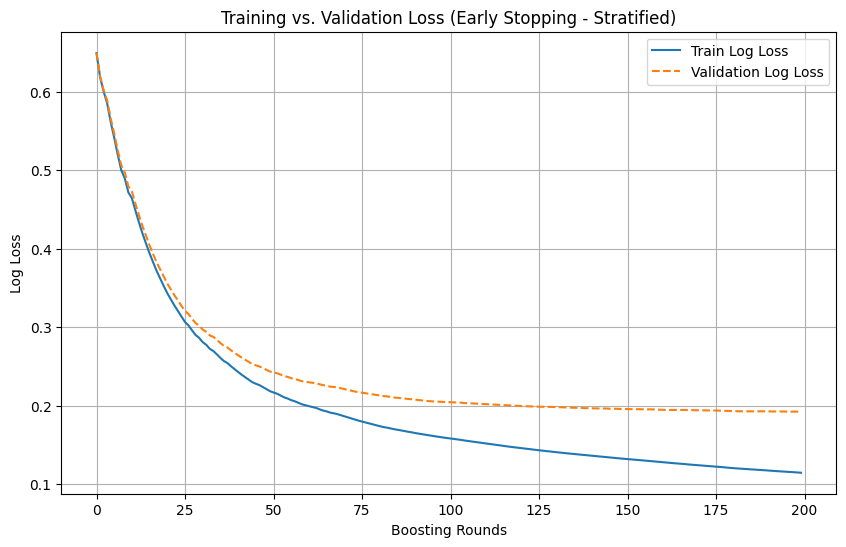

Optimal Classification Threshold: 0.3779

=== Confusion Matrix ===
[[ 575   72]
 [  98 1276]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       647
           1       0.95      0.93      0.94      1374

    accuracy                           0.92      2021
   macro avg       0.90      0.91      0.90      2021
weighted avg       0.92      0.92      0.92      2021



In [ ]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report

# Define hyperparameter grid for Stratified XGBoost
xgb_stratified_param_grid = {
    "n_estimators": [200, 300],  # Number of boosting rounds
    "max_depth": [7, 9],  # Maximum tree depth
    "learning_rate": [0.05],  # Learning rate
    "subsample": [0.9],  # Subsample ratio
    "colsample_bytree": [0.8],  # Feature subsample ratio per tree
    "gamma": [0.4],  # Minimum loss reduction
    "reg_alpha": [1, 2, 4],  # L1 regularization term
    "reg_lambda": [5, 10],  # L2 regularization term
    "min_child_weight": [4, 6],  # Minimum sum of instance weight
    "scale_pos_weight": [0.4, 0.5],  # Balancing of positive and negative weights
}

# Define Stratified Cross-Validation strategy
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=420)

# Initialize GridSearchCV with XGBoost
xgb_stratified_gridsearch = GridSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=420,
        eval_metric="logloss",
        use_label_encoder=False
    ),
    param_grid=xgb_stratified_param_grid,
    scoring="roc_auc",  # Prioritize AUC
    cv=stratified_cv,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
xgb_stratified_gridsearch.fit(
    X_train_clean_mean, y_train_clean,
    eval_set=[(X_test_clean_mean, y_test_clean)],
    verbose=True
)

# Get best model hyperparameters
best_params = xgb_stratified_gridsearch.best_params_
print("\n=== Best Hyperparameters for Stratified XGBoost ===")
print(best_params)

# ✅ Recreate Best Model with Early Stopping
best_xgb_stratified = xgb.XGBClassifier(
    **best_params,  # Load the best hyperparameters
    random_state=420,
    eval_metric="logloss",
    use_label_encoder=False
)

# Define evaluation set
eval_set = [(X_train_clean_mean, y_train_clean), (X_test_clean_mean, y_test_clean)]

# Train the best model with early stopping
best_xgb_stratified.fit(
    X_train_clean_mean, y_train_clean,
    eval_set=eval_set,
    early_stopping_rounds=20,
    verbose=True
)

# ✅ Evaluate using extended evaluation function
xgb_tuned_eval = evaluate_model_extended(
    best_xgb_stratified,
    X_test_clean_mean,
    y_test_clean,
    model_name="Tuned Stratified XGBoost"
)

# ✅ Extract results & confusion matrix
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = xgb_tuned_eval
y_pred = (y_prob >= 0.5).astype(int)  # Default threshold at 0.5
cm_tuned = confusion_matrix(y_test_clean, y_pred)

# ✅ Store results in the correct format
results_xgb["Tuned Stratified XGBoost"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_tuned, y_prob
)

# ✅ Extract training history
stratified_results = best_xgb_stratified.evals_result()

# ✅ Plot Training vs. Validation Log Loss
plt.figure(figsize=(10, 6))
plt.plot(stratified_results["validation_0"]["logloss"], label="Train Log Loss", linestyle="-")
plt.plot(stratified_results["validation_1"]["logloss"], label="Validation Log Loss", linestyle="--")
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Training vs. Validation Loss (Early Stopping - Stratified)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Predict probabilities
y_prob = best_xgb_stratified.predict_proba(X_test_clean_mean)[:, 1]

# ✅ Find the best classification threshold
precisions, recalls, thresholds = precision_recall_curve(y_test_clean, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Classification Threshold: {best_threshold:.4f}")

# ✅ Apply the new threshold
y_pred_opt = (y_prob >= best_threshold).astype(int)

# ✅ Generate evaluation metrics
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test_clean, y_pred_opt))

print("\n=== Classification Report ===")
print(classification_report(y_test_clean, y_pred_opt))

# ✅ Store results
results_xgb["Tuned Stratified XGBoost"] = (
    classification_report(y_test_clean, y_pred_opt, output_dict=True),
    confusion_matrix(y_test_clean, y_pred_opt),
    best_threshold
)


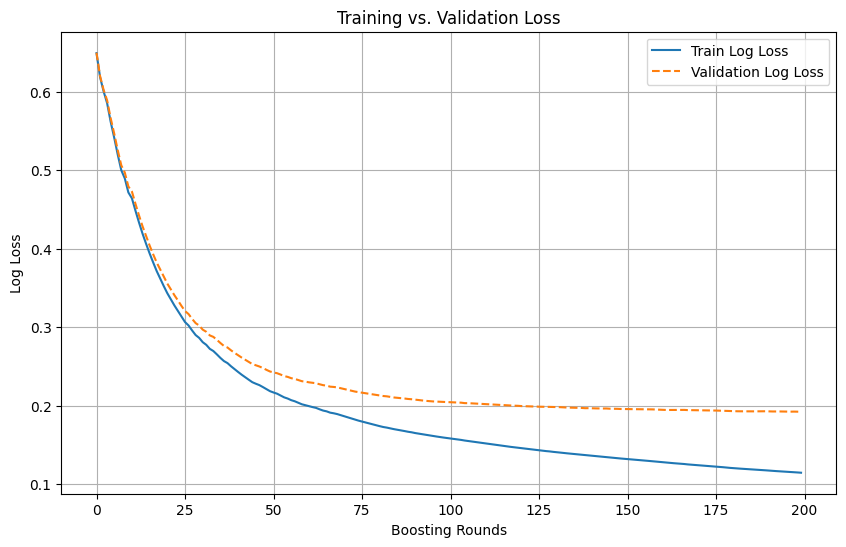

In [122]:
import matplotlib.pyplot as plt

# Extract training and validation log loss
train_loss = stratified_results["validation_0"]["logloss"]
val_loss = stratified_results["validation_1"]["logloss"]

# Plot Log Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Log Loss", linestyle="-")
plt.plot(val_loss, label="Validation Log Loss", linestyle="--")
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [115]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Training Predictions
y_train_pred = best_xgb_stratified.predict(X_train_clean_mean)
y_train_prob = best_xgb_stratified.predict_proba(X_train_clean_mean)[:, 1]

# Test Predictions
y_test_pred = best_xgb_stratified.predict(X_test_clean_mean)
y_test_prob = best_xgb_stratified.predict_proba(X_test_clean_mean)[:, 1]

# Compute Metrics
train_acc = accuracy_score(y_train_clean, y_train_pred)
test_acc = accuracy_score(y_test_clean, y_test_pred)
train_auc = roc_auc_score(y_train_clean, y_train_prob)
test_auc = roc_auc_score(y_test_clean, y_test_prob)
train_f1 = f1_score(y_train_clean, y_train_pred)
test_f1 = f1_score(y_test_clean, y_test_pred)

# Print Metrics
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")
print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")


Train Accuracy: 0.9588, Test Accuracy: 0.9045
Train AUC: 0.9972, Test AUC: 0.9748
Train F1: 0.9688, Test F1: 0.9269


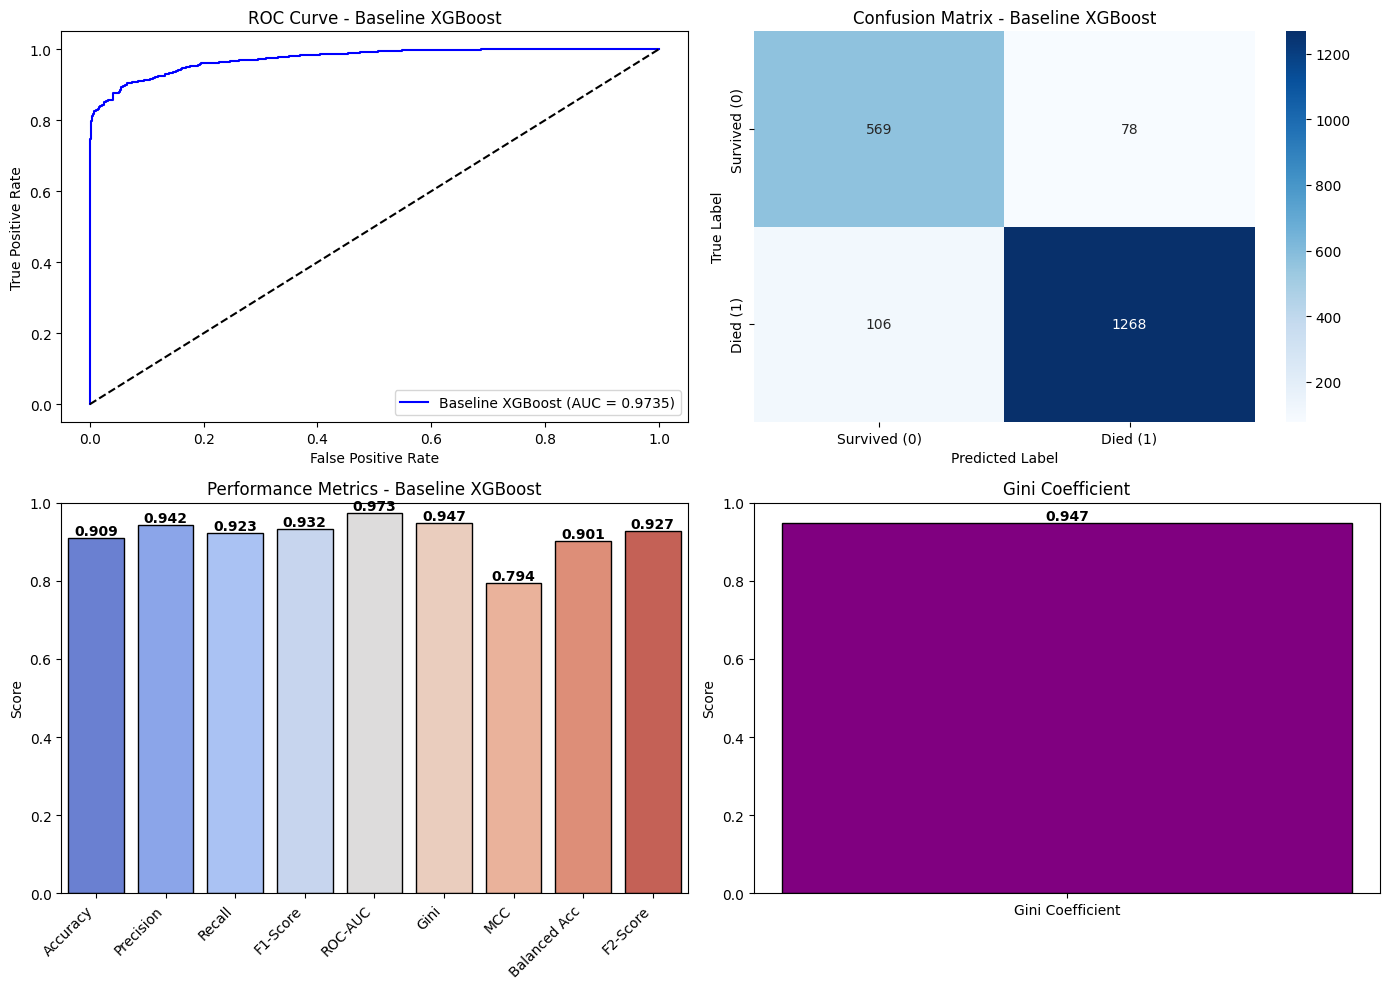

Evaluation plot saved to: ../visualizations\xgb_baseline_xgboost_evaluation.png

=== XGBoost Model Performance Summary ===
                  Accuracy  Precision    Recall  F1-Score   ROC-AUC      Gini  \
Baseline XGBoost  0.908956   0.942051  0.922853  0.932353  0.973488  0.946975   

                       MCC  Balanced Accuracy  F2-Score  
Baseline XGBoost  0.793608           0.901148   0.92663  


In [133]:
# Evaluate & plot XGBoost models
evaluate_and_plot_model_extended(
    results_xgb,  # dictionary with the 3 XGB models
    y_test_clean, 
    output_dir="../visualizations", 
    prefix="xgb"
)

# Summarize in a DataFrame
xgb_performance_summary = pd.DataFrame.from_dict(
    results_xgb,
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)

# Drop unneeded columns and sort by ROC-AUC
xgb_performance_summary.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
xgb_performance_summary.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== XGBoost Model Performance Summary ===")
print(xgb_performance_summary)


In [90]:
import joblib

import pickle

print("Joblib and pickle are already installed!")

Joblib and pickle are already installed!


In [30]:
import pickle

# Create a directory for saving models/results
os.makedirs("../XGBOOST", exist_ok=True)

# Save trained XGBoost model
joblib.dump(xgb_baseline, "../XGBOOST/xgb_baseline.pkl")

# Save evaluation results
with open("../XGBOOST/results_xgb.pkl", "wb") as f:
    pickle.dump(results_xgb, f)

print("XGBoost model and results saved successfully!")


XGBoost model and results saved successfully!
